In [ ]:
#!pip install wandb
#!wandb login 8a324ea566a522594128b232367eac1d2858e5de


# all-MiniLM-L6-v2-biencoder-trained-final-0304 REQUIRES TITLE ONLY !


# 6 evaluate BI-encoder

In [12]:
import sys
sys.path.append('/kaggle/input/sentence-transformers')
sys.path.append('/kaggle/input/sentence-embedding-models')
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
import string
from sentence_transformers import SentenceTransformer,InputExample,util, CrossEncoder,losses
import torch
from torch.utils.data import DataLoader
from sentence_transformers import losses

tqdm.pandas()

BASE_DIR = '/kaggle/input/learning-equality-curriculum-recommendations'
BASE_DIR = 'C:/learning'

content_data = pd.read_csv(os.path.join(BASE_DIR,'content.csv'))
correlations_data = pd.read_csv(os.path.join(BASE_DIR,'correlations.csv'))
topics_data = pd.read_csv(os.path.join(BASE_DIR,'topics.csv'))
sub_data = pd.read_csv(os.path.join(BASE_DIR,'sample_submission_0305.csv'))


#model_trained = SentenceTransformer('C:/Users/Dmitriy/Desktop/proj7/all-MiniLM-L6-v2-biencoder-trained-final-0304')

model_trained = SentenceTransformer("bi-final-0313b")   # was bi-final-0308


# We will create some dictionaries and lists to move between topics, contents and targets
t2i = {k:i for i,k in enumerate(topics_data['id'].values.tolist())}
i2c = {i:k for i,k in enumerate(content_data['id'].values.tolist())}
topics_test = correlations_data['topic_id'].values.tolist()
targets_test = correlations_data['content_ids'].values.tolist()


# METRICS
def precision(targets, preds): return len([x for x in targets if x in preds])/(len(set(targets+preds))+ 1e-16)
def recall(targets, preds): return len([x for x in targets if x in preds])/(len(targets)+ 1e-16)
def f2(targets, preds, beta=2):
    p = precision(targets, preds)
    r = recall(targets, preds)
    F2 = (1 + beta**2) * p * r / (beta**2 * p + r + 1e-16)
    return F2
def f2mean(listtargs, listpreds):
    f2s = [f2(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(f2s)
def recmean(listtargs, listpreds):
    recs = [recall(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(recs)
def precmean(listtargs, listpreds):
    precs = [precision(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(precs)

#topics_data['merged_text'] = topics_data['title'].fillna(' ')
#content_data['merged_text'] =  content_data['title'].fillna(' ')
#topics_data['merged_text'] = topics_data['title'].fillna(' ') + ' [SEP] ' + topics_data['description'].fillna(' ')
#content_data['merged_text'] =  content_data['title'].fillna(' ') + ' [SEP] ' + content_data['description'].fillna(' ')


parentmap = topics_data.set_index('id')['title'].squeeze()
topics_data['parent_title'] = topics_data['parent'].map(parentmap)
topics_data['merged_text'] = topics_data['title'].fillna(' ').str.lower() + ' [SEP] ' + topics_data['description'].fillna(' ').str.lower() \
    +  ' [SEP] ' + topics_data['parent_title'].fillna(' ').str.lower()
content_data['merged_text'] =  content_data['title'].fillna(' ').str.lower() + ' [SEP] ' + content_data['description'].fillna(' ').str.lower()\
    +  ' [SEP] ' + content_data['text'].fillna(' ').str.lower().str[:100]



content_emb = model_trained.encode(content_data['merged_text'],  show_progress_bar = True)  # 2 минуты
topic_emb = model_trained.encode(topics_data['merged_text'],  show_progress_bar = True) 

import faiss
k = 40

index = faiss.IndexFlatL2(content_emb.shape[-1])   # build the index
index.add(content_emb) # add vectors to the index
D, I = index.search(topic_emb, k) # actual search

topic_knn = [' '.join([i2c[x] for x in p]) for p in I.tolist()]
predictions = [topic_knn[t2i[i]] for i in topics_test]      # based on topics in correlations

recall = recmean(targets_test, predictions)

print(recall)


# при k=100 результат recall =  0.86 для 'C:/Users/Dmitriy/Desktop/proj4/all-MiniLM-L6-v2-biencoder-trained-final'
# при k=50 результат recall =  0.82 для 'C:/Users/Dmitriy/Desktop/proj4/all-MiniLM-L6-v2-biencoder-trained-final'
# при k=20 результат recall =  0.809 для 'all-MiniLM-L6-v2-biencoder-trained-final-0304'

# при k=20 результат recall =  0.869 для bi-final-0308
# при k=100 результат recall =  0.94 для bi-final-0308

# при k=50 результат recall =  0.95 для bi-final-0313
# при k=100 результат recall =  0.96 для bi-final-0313

Batches:   0%|          | 0/4814 [00:00<?, ?it/s]

Batches:   0%|          | 0/2406 [00:00<?, ?it/s]

0.946412516646541


In [13]:
def precision(targets, preds): return len([x for x in targets if x in preds])/(len(set(targets+preds))+ 1e-16)
def recall(targets, preds): return len([x for x in targets if x in preds])/(len(targets)+ 1e-16)
def f2(targets, preds, beta=2):
    p = precision(targets, preds)
    r = recall(targets, preds)
    F2 = (1 + beta**2) * p * r / (beta**2 * p + r + 1e-16)
    return F2
def f2mean(listtargs, listpreds):
    f2s = [f2(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(f2s)
def recmean(listtargs, listpreds):
    recs = [recall(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(recs)
def precmean(listtargs, listpreds):
    precs = [precision(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(precs)

print('f2= ',f2mean(targets_test, predictions))


# f2 = 0.4016666909862911 для knn=20 для all-MiniLM-L6-v2-biencoder-trained-final-0304
# f2=  0.42558947046742335 для knn = 20 для bi-final-0308

f2=  0.30554550507590084


# 7 evaluate classifier - Cross Encoder Based

In [14]:
# переключить на единый merged_text

from torch import nn
from sentence_transformers import util

sub_data = pd.read_csv(os.path.join(BASE_DIR,'sample_submission_0305.csv'))
#topics_data['merged_text2'] = topics_data['title'].fillna(' ') + ' [SEP] ' + topics_data['description'].fillna(' ')
#content_data['merged_text2'] =  content_data['title'].fillna(' ') + ' [SEP] ' + content_data['description'].fillna(' ')

#x-final-0311b

x_encoder = CrossEncoder('x-final-0313',num_labels=1, max_length=128, default_activation_function=nn.Sigmoid())

topics_sub = sub_data['topic_id'].values.tolist()
#topics_sub = topics_test                             # ONLY FOR EVALUATION  submission = correlation (test) list of topics 

predictions_sub = [topic_knn[t2i[i]] for i in topics_sub]  # based on topics in submission
predictions_sub_real=[]

for t_idx, t_row in tqdm(enumerate(topics_sub), total=len(topics_sub), position=0, leave=True):
    lang = topics_data.query(f'id=="{t_row}"')['language'].values[0]
    top_name = topics_data.query(f'id=="{t_row}"')['merged_text'].values[0]
    now_topic_emb = model_trained.encode(top_name,  show_progress_bar = False)  
    cont_list = predictions_sub[t_idx].split()
    
    
    # выберем значения и ОТСОРТИРУЕМ по списку индексов
    temp_df = content_data.query(f'id in {cont_list}')[['id','merged_text']] # make dataframe with valid values
    sorterIndex = dict(zip(cont_list, range(len(cont_list))))                 # make artificial index for cont_list
    temp_df['tm_rank'] =temp_df['id'].map(sorterIndex)                        # make new column with artificial index for dataframe
    temp_df = temp_df.sort_values(["tm_rank"])                                # now just sort
    cont_name_list = temp_df["merged_text"].values.tolist() 
    cross_inp = [[top_name, x] for x in cont_name_list]
    y_pred = x_encoder.predict(cross_inp, show_progress_bar = False)
    

    # доп проверка по cosine similarity + target function 
    #now_topic_emb = model_trained.encode(top_name,  show_progress_bar = False)
    #now_content_emb = model_trained.encode(cont_name_list,  show_progress_bar = False)
    #now_cos_scores = util.cos_sim( now_topic_emb, now_content_emb)[0]
    #a_arr = np.array(now_cos_scores.tolist())
    #b_arr = y_pred
    #target_function  = (a_arr>0.7).astype(int) + (b_arr>100.0).astype(int)
    #target_function  = target_function.tolist()
    target_function  = [0]
    
    # выберем занчения по  score threshold из списка y_pred
    p_list = predictions_sub[t_idx].split()                    # разберем строку в список 
    #y_list = [float(x[0]) for x in y_pred]                     # переформатируем вложенный список просто в список цифр
    y_list = y_pred
    
    
    real_p = [j for (i,j) in zip(y_list,p_list) if i >= 0.085 ]
    '''
    # проверка по языку пока провалилась 
    if lang in ['en','es','pt','bg']:
            real_p = [j for (i,j) in zip(y_list,p_list) if i >= 0.150 ]        
    else:  # для прочих языков смотримм только биэнкодер
            real_p = [j for (i,j) in zip(target_function,p_list) if i >= 1 ]  
    '''
    
    #нужно сделать соответсвующий (отсортированный по исходному) список языков по списку real_p
    #затем по спиcку языков отобрать только те значения из real_p, которые подходят по языку
    temp_df = content_data.query(f'id in {real_p}')[['id','language']]    # make dataframe with valid values
    sorterIndex = dict(zip(real_p, range(len(real_p))))                   # make artificial index for cont_list
    temp_df['tm_rank'] =temp_df['id'].map(sorterIndex)                    # make new column with artificial index for dataframe
    temp_df = temp_df.sort_values(["tm_rank"])                            # now just sort
    lang_name_list = temp_df["language"].values.tolist() 
    real_p_lang = [j for (i,j) in zip(lang_name_list,real_p) if i ==lang ]# выберем из списка real_p только нужные значения

    real_p = ' '.join(real_p_lang)                                  # соберем обратно список в строку
    predictions_sub_real.append(real_p)

    
    if t_idx==-1:                           # debug log 
        print (lang)
        print(' ')
        print (now_cos_scores.tolist())     # score by biencoder
        print(' ')
        print (y_pred.tolist())             # score by cross encoder 
        print(' ')
        print (target_function)             # TARGET FUNCTION - do we need this ? 
        print(' ')
        print(predictions_sub[t_idx])       # черновой список предсказаний от биэнкодера
        print(' ')
        print(predictions_sub_real[t_idx])  # чистовой список предсказаний 
        print(' ')
        print (targets_test[t_idx])         # ground truth 
        raise_exception + 1

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.85it/s]


In [15]:
def precision(targets, preds): return len([x for x in targets if x in preds])/(len(set(targets+preds))+ 1e-16)
def recall(targets, preds): return len([x for x in targets if x in preds])/(len(targets)+ 1e-16)
def f2(targets, preds, beta=2):
    p = precision(targets, preds)
    r = recall(targets, preds)
    F2 = (1 + beta**2) * p * r / (beta**2 * p + r + 1e-16)
    return F2
def f2mean(listtargs, listpreds):
    f2s = [f2(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(f2s)
def recmean(listtargs, listpreds):
    recs = [recall(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(recs)
def precmean(listtargs, listpreds):
    precs = [precision(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(precs)

print('f2= ',f2mean(targets_test[0:500], predictions_sub_real))
#print('f2= ',f2mean(targets_test, predictions_sub_real))
#f2=  0.39056572692027614 при 0.000 для первых 500 записей
#f2=  0.4227819896651239 при 0.010 для ms-marco-MiniLM-L-6-v2-Xencoder-trained
#f2=  0.48893033383460716 при 0.010 для Xencoder-0307 для первых 500 записей   
#f2=  0.47 при 0.010 для Xencoder-0307b
#f2=  0.5713877651485273 при 0.010 для Xencoder-0307 для всех записей
#f2=  0.5911840820159854 при 0.010 для Xencoder-0307 для всех записей с контролем языка - knn 20
#f2=  0.5860484411866054 при 0.010 для x-final-0310 для всех записей с контролем языка - knn 20
# перетренируем под примеры из 50knn - новый x-final-0310
# f2= 0.6194419371519712 при 0.010 для нового x-final-0310 для всех записей с контролем языка - knn 15
# f2= 0.6147544962292057 при 0.015 для нового x-final-0310 для всех записей с контролем языка - knn 20
# f2= 0.6371912793386234 при 0.025 для нового x-final-0310 для всех записей с контролем языка - knn 20
# f2= 0.6486908951297519 при 0.045 для нового x-final-0310 для всех записей с контролем языка - knn 20
# f2= 0.6841105925853587 при 0.045 для нового x-final-0311b для всех записей с контролем языка - knn 20  === сравнивать с этим 
# f2= 0.6713434305381343 при 0.065 для нового x-final-0311b для всех записей с контролем языка - knn 40
#новый x-final-0313
# f2= 0.7250377317831915 при 0.045 для нового x-final-0313 для всех записей с контролем языка - knn 20

f2=  0.7133275285467857


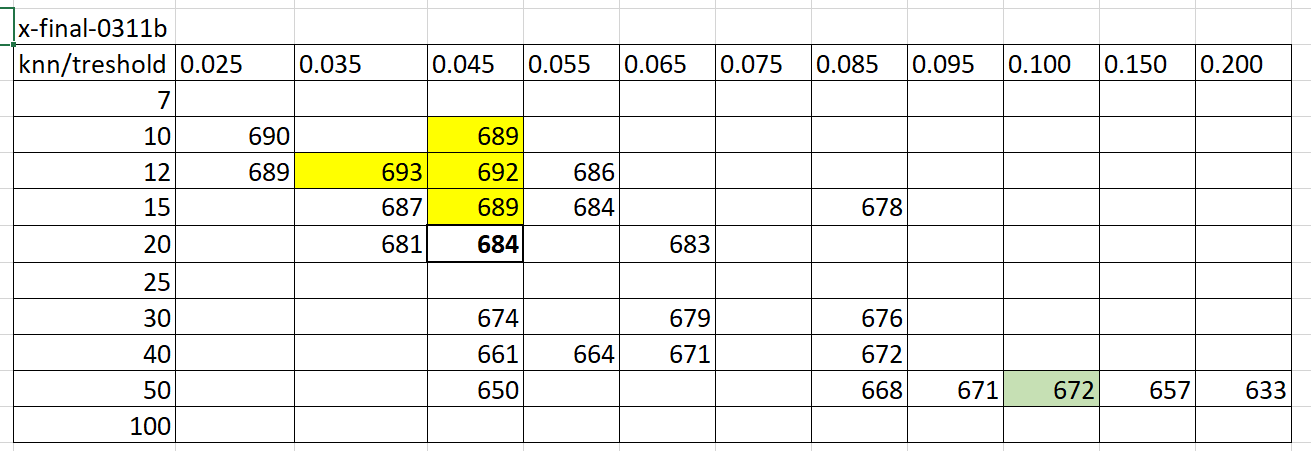

In [116]:
err=0
print(len(targets_test))

for index, element in enumerate(targets_test):
    lang1=[]
    lang2=[]  
    for sub_element in element.split():
        curr_lang = content_data.query(f'id=="{sub_element}"')['language'].values[0]
        if curr_lang not in lang1: lang1.append(curr_lang)
    for sub_element in predictions_sub_real[index].split():
        curr_lang = content_data.query(f'id=="{sub_element}"')['language'].values[0]
        if curr_lang not in lang2: lang2.append(curr_lang)
    if lang1!= lang2: 
        err= err+1
        print (index,err,lang1, lang2)

61517
4 1 ['gu'] ['my', 'gu']
6 2 ['en'] ['en', 'it']
13 3 ['te'] ['pnb', 'gu', 'or', 'kn']
17 4 ['pt'] ['en', 'es', 'pt', 'it']
23 5 ['en'] ['en', 'it', 'sw', 'hi']
26 6 ['pt'] ['pt', 'es']
27 7 ['gu'] ['km', 'my', 'kn', 'as', 'gu']
28 8 ['pt'] ['pt', 'es']
29 9 ['en'] ['es', 'en', 'my']
30 10 ['sw'] ['sw', 'en', 'hi']
32 11 ['en'] ['en', 'fr']
33 12 ['es'] ['es', 'pt']
36 13 ['en'] ['sw', 'en']
41 14 ['en'] ['en', 'fr']
44 15 ['mr'] ['hi', 'mr']
50 16 ['gu'] ['gu', 'my']
54 17 ['sw'] ['en', 'sw', 'it']
57 18 ['pt'] ['pt', 'es']
62 19 ['en'] ['en', 'es', 'fr']
69 20 ['en'] ['en', 'fil']
72 21 ['sw'] ['it', 'en', 'sw']
74 22 ['fr'] ['fr', 'en']
78 23 ['en'] ['en', 'ur']
79 24 ['en'] ['en', 'hi']
84 25 ['en'] ['en', 'es']
86 26 ['gu'] ['gu', 'my']
89 27 ['en'] ['en', 'es']
90 28 ['gu'] ['km', 'my', 'kn', 'as', 'gu']
92 29 ['en'] ['en', 'sw']
93 30 ['en'] ['en', 'pt', 'tr', 'es']
96 31 ['bn'] ['bn', 'as']
98 32 ['bn'] ['bn', 'en']
102 33 ['en'] ['en', 'sw']
103 34 ['en'] ['en', 'hi', 'gu

869 265 ['en'] ['en', 'gu']
873 266 ['ar', 'pt', 'en'] ['en', 'pt', 'ar', 'sw']
877 267 ['en'] ['en', 'sw']
881 268 ['pt'] ['pt', 'es']
882 269 ['gu'] ['gu', 'mr', 'or', 'te', 'hi', 'kn']
885 270 ['en'] ['en', 'fr']
887 271 ['en'] ['hi', 'en', 'it']
890 272 ['es'] []
893 273 ['en', 'es'] ['es', 'en']
895 274 ['gu'] ['gu', 'en', 'sw']
896 275 ['es'] ['es', 'pt']
898 276 ['es'] ['es', 'pt']
900 277 ['pt'] ['pt', 'es']
902 278 ['en'] ['en', 'gu']
903 279 ['gu'] ['gu', 'pnb', 'or', 'kn']
908 280 ['en'] ['en', 'hi', 'sw']
910 281 ['sw'] ['en', 'sw', 'es']
921 282 ['gu'] ['gu', 'zh', 'or']
925 283 ['hi'] ['hi', 'en']
930 284 ['pt'] ['pt', 'es']
935 285 ['en'] ['en', 'pt']
937 286 ['en'] ['en', 'sw']
940 287 ['es'] []
944 288 ['pt'] ['pt', 'es']
946 289 ['sw'] ['en', 'sw']
947 290 ['bg'] ['bg', 'ru']
948 291 ['kn'] ['km', 'my', 'kn', 'as', 'gu']
949 292 ['en'] ['en', 'bn', 'it']
951 293 ['es'] ['es', 'pt']
953 294 ['bn'] ['bn', 'en', 'it']
954 295 ['fr'] ['fr', 'en']
958 296 ['sw'] ['en', 'fr

1680 515 ['hi'] ['hi', 'en']
1682 516 ['sw'] ['sw', 'en']
1684 517 ['en'] ['en', 'hi']
1692 518 ['en'] ['en', 'sw']
1694 519 ['kn'] ['pnb', 'gu', 'or', 'kn']
1696 520 ['en'] ['en', 'it', 'bn', 'pt']
1697 521 ['es'] ['es', 'pt']
1707 522 ['gu'] ['kn', 'as', 'gu']
1708 523 ['gu'] ['gu', 'mr', 'or', 'te', 'hi', 'kn']
1711 524 ['en'] ['en', 'hi']
1718 525 ['es'] ['es', 'pt']
1719 526 ['te'] ['gu', 'mr', 'or', 'te', 'kn']
1722 527 ['gu'] ['gu', 'ta', 'pnb']
1723 528 ['sw'] ['sw', 'it', 'en']
1725 529 ['en'] ['en', 'sw']
1733 530 ['fr'] ['fr', 'pl']
1744 531 ['hi'] ['mr', 'hi']
1745 532 ['gu'] ['gu', 'km', 'my', 'zh']
1751 533 ['gu'] ['km', 'my', 'kn', 'as', 'gu']
1752 534 ['sw'] ['en', 'sw']
1757 535 ['en'] ['en', 'it', 'sw']
1758 536 ['gu'] ['gu', 'zh', 'or']
1759 537 ['en'] ['en', 'it']
1762 538 ['en'] ['sw', 'en']
1769 539 ['en'] ['es', 'en', 'my']
1770 540 ['en'] ['en', 'gu', 'sw']
1773 541 ['es'] []
1780 542 ['es'] []
1781 543 ['kn'] ['kn', 'as', 'gu']
1787 544 ['en'] ['en', 'it', 'gu'

2576 771 ['es'] ['es', 'pt']
2578 772 ['en'] ['en', 'it', 'sw']
2583 773 ['gu'] ['gu', 'or', 'zh']
2586 774 ['es'] ['es', 'pt']
2594 775 ['en'] ['en', 'fr']
2596 776 ['sw'] ['en', 'sw']
2599 777 ['en'] ['en', 'it', 'sw']
2600 778 ['gu'] ['gu', 'my', 'kn', 'zh']
2604 779 ['fil'] ['fil', 'es']
2608 780 ['gu'] ['gu', 'mr', 'or', 'te', 'hi', 'kn']
2614 781 ['te'] ['gu', 'mr', 'or', 'te', 'kn', 'pnb']
2615 782 ['as'] ['as', 'bn', 'kn', 'te']
2616 783 ['es'] ['es', 'pt']
2626 784 ['sw'] ['en', 'sw', 'bn']
2631 785 ['en'] ['en', 'es']
2641 786 ['en'] ['en', 'hi']
2642 787 ['es'] []
2645 788 ['es'] ['es', 'en', 'pt']
2648 789 ['en'] ['en', 'fil']
2650 790 ['en'] ['en', 'it']
2661 791 ['en'] ['it', 'en']
2662 792 ['en'] ['en', 'fil']
2666 793 ['fr'] ['fr', 'pt', 'en']
2669 794 ['en'] ['en', 'it']
2670 795 ['es'] ['es', 'pt']
2672 796 ['fr'] ['fr', 'es', 'tr']
2677 797 ['es'] ['es', 'pt']
2679 798 ['gu'] ['gu', 'kn', 'zh', 'te']
2680 799 ['en'] ['en', 'it']
2685 800 ['pt'] ['pt', 'es']
2688 801 

3396 1019 ['en'] ['en', 'sw']
3399 1020 ['sw'] ['en', 'sw', 'gu', 'bg']
3403 1021 ['it'] ['it', 'pt']
3405 1022 ['en'] ['en', 'es']
3410 1023 ['hi'] ['hi', 'mr']
3414 1024 ['sw'] ['sw', 'en', 'it']
3416 1025 ['pt'] ['pt', 'es']
3419 1026 ['en'] ['en', 'hi']
3420 1027 ['en'] ['en', 'pt', 'gu']
3425 1028 ['en'] ['en', 'it']
3426 1029 ['es'] []
3427 1030 ['ar'] ['ar', 'pt', 'en', 'es']
3428 1031 ['en'] ['en', 'fr']
3432 1032 ['es'] ['en', 'es', 'pt', 'bg']
3438 1033 ['es'] []
3449 1034 ['fr'] ['fr', 'es']
3453 1035 ['pt'] ['pt', 'fr', 'es']
3455 1036 ['en'] ['en', 'it']
3459 1037 ['km'] ['km', 'kn', 'my', 'as', 'gu']
3463 1038 ['pt'] ['es']
3465 1039 ['es'] ['es', 'pt']
3466 1040 ['en'] ['es', 'en']
3467 1041 ['gu'] ['my', 'gu']
3469 1042 ['sw'] ['it', 'sw']
3470 1043 ['en'] ['en', 'hi']
3472 1044 ['km'] ['km', 'kn', 'my', 'as', 'gu']
3476 1045 ['sw'] ['en', 'sw']
3478 1046 ['gu'] ['kn', 'pnb', 'gu', 'or']
3484 1047 ['en'] ['en', 'sw']
3485 1048 ['fr'] ['fr', 'en']
3488 1049 ['en', 'es'] 

4197 1265 ['es'] []
4200 1266 ['es'] []
4204 1267 ['pt'] ['pt', 'it', 'en', 'es']
4208 1268 ['en'] ['en', 'it', 'sw']
4212 1269 ['sw'] ['en', 'sw']
4214 1270 ['sw'] ['en', 'hi', 'sw']
4215 1271 ['gu'] ['gu', 'my']
4218 1272 ['pt'] ['pt', 'es']
4219 1273 ['sw'] ['en', 'sw']
4223 1274 ['en'] ['en', 'it']
4225 1275 ['en'] ['en', 'es']
4226 1276 ['en'] ['es', 'en', 'my']
4227 1277 ['es'] []
4231 1278 ['sw'] ['en', 'sw', 'it']
4232 1279 ['pt'] ['pt', 'es']
4235 1280 ['pt'] ['pt', 'es']
4237 1281 ['fr'] ['fr', 'en']
4246 1282 ['gu'] ['zh', 'gu']
4248 1283 ['pt'] ['pt', 'es']
4249 1284 ['pt'] ['pt', 'es']
4252 1285 ['en'] ['en', 'it', 'sw']
4257 1286 ['en'] ['en', 'it']
4263 1287 ['es'] []
4264 1288 ['es'] ['es', 'en']
4269 1289 ['en'] ['es', 'en', 'my']
4271 1290 ['en'] ['en', 'swa']



KeyboardInterrupt



In [114]:
index

4

In [113]:
lang2

['my', 'gu']

# 7A evaluate classifier - RNN based

In [3]:
# модель у тебя трескает готовые embeddings 
# мне нужно сформировать пары EMBEDDINGS query и content и потом склеить их при помощи hstack ? или скормить dot product ?
# и это должно работать быстро в условиях 16 гигабайт оперативки...

#X = np.hstack ((now_topic_emb,now_content_emb))

In [4]:
import torch
import numpy as np 
import torch.nn as nn

width = 768   # before 768

sub_data = pd.read_csv(os.path.join(BASE_DIR,'sample_submission_0305.csv'))



class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(width, width)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(width, width)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(width, width)
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.15)
        self.output = nn.Linear(width, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.dropout(x)
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x



model = torch.load('classifier-0304')  # 0304 before
device = torch.device("cuda")
model.to(device)

topics_sub = sub_data['topic_id'].values.tolist()
#topics_sub = topics_test                             # ONLY FOR EVALUATION  submission = correlation (test) list of topics 

predictions_sub = [topic_knn[t2i[i]] for i in topics_sub]  # based on topics in submission
predictions_sub_real=[]

for t_idx, t_row in tqdm(enumerate(topics_sub), total=len(topics_sub), position=0, leave=True):
    lang = topics_data.query(f'id=="{t_row}"')['language'].values[0]
    top_name = topics_data.query(f'id=="{t_row}"')['merged_text'].values[0]
    now_topic_emb = model_trained.encode(top_name,  show_progress_bar = False)  
    cont_list = predictions_sub[t_idx].split()
    #cont_name_list = content_data.query(f'id in {cont_list}')['merged_text'].values.tolist()  # порядок другой !
    # выберем значения и ОТСОРТИРУЕМ по списку индексов
    temp_df = content_data.query(f'id in {cont_list}')[['id','merged_text']]  # make dataframe with valid values
    sorterIndex = dict(zip(cont_list, range(len(cont_list))))                 # make artificial index for cont_list
    temp_df['tm_rank'] =temp_df['id'].map(sorterIndex)                        # make new column with artificial index for dataframe
    temp_df = temp_df.sort_values(["tm_rank"])                                # now just sort
    cont_name_list = temp_df["merged_text"].values.tolist() 
    
    now_content_emb = model_trained.encode(cont_name_list,  show_progress_bar = False) 
    now_topic_emb = np.tile(now_topic_emb, (k, 1))
    X = np.hstack ((now_topic_emb,now_content_emb))
    #X = now_topic_emb - now_content_emb
    
    model.eval()
    with torch.no_grad():
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to("cuda")
        y_pred = model(X).cpu().tolist()
        
    # выберем занчения по  score threshold из списка y_pred
    p_list = predictions_sub[t_idx].split()                    # разберем строку в список 
    y_list = [float(x[0]) for x in y_pred]                     # переформатируем вложенный список просто в список цифр
    real_p = [j for (i,j) in zip(y_list,p_list) if i >= 0.1 ]  # выберем из списка p_list только те значения у которых y_list >0.1



    #нужно сделать соответсвующий (отсортированный по исходному) список языков по списку real_p
    #затем по спиcку языков отобрать только те значения из real_p, которые подходят по языку
    temp_df = content_data.query(f'id in {real_p}')[['id','language']]    # make dataframe with valid values
    sorterIndex = dict(zip(real_p, range(len(real_p))))                   # make artificial index for cont_list
    temp_df['tm_rank'] =temp_df['id'].map(sorterIndex)                    # make new column with artificial index for dataframe
    temp_df = temp_df.sort_values(["tm_rank"])                            # now just sort
    lang_name_list = temp_df["language"].values.tolist() 
    real_p_lang = [j for (i,j) in zip(lang_name_list,real_p) if i ==lang ]# выберем из списка real_p только нужные значения


    real_p = ' '.join(real_p_lang)                                  # соберем обратно список в строку
    predictions_sub_real.append(real_p)

        
    if t_idx==-1:
        print (now_cos_scores.tolist())     # score by  biencoder
        print('    ')
        print (y_list)                      # score by cross encoder 
        print('    ')
        print (predictions_sub[t_idx])      # черновой список предсказаний от биэнкодера
        print('    ')
        print(predictions_sub_real[t_idx])  # чистовой спсиок предсказаний 
        print('    ')
        print (targets_test[t_idx])         # ground truth 
        fdff+1
        


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:27<00:00, 17.96it/s]


In [5]:
def precision(targets, preds): return len([x for x in targets if x in preds])/(len(set(targets+preds))+ 1e-16)
def recall(targets, preds): return len([x for x in targets if x in preds])/(len(targets)+ 1e-16)
def f2(targets, preds, beta=2):
    p = precision(targets, preds)
    r = recall(targets, preds)
    F2 = (1 + beta**2) * p * r / (beta**2 * p + r + 1e-16)
    return F2
def f2mean(listtargs, listpreds):
    f2s = [f2(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(f2s)
def recmean(listtargs, listpreds):
    recs = [recall(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(recs)
def precmean(listtargs, listpreds):
    precs = [precision(t.split(' '),p.split(' ')) for t,p in list(zip(listtargs, listpreds))]
    return np.nanmean(precs)

print('f2= ',f2mean(targets_test[0:500], predictions_sub_real))

# f2=  0.6334268660694921 при 0.100 для classifier-0304 для перых 500 записей
# f2=  0.5160585158735975 при 0.100 для classifier-0308 для перых 500 записей

f2=  0.6334268660694921


# 8 convert to submission

In [ ]:
sub_data.loc[:,'content_ids'] = predictions_sub_real
sub_data.to_csv('submission.csv',index=False)
sub_data.head()

In [ ]:
# 4 ideas
add TT link
train with 100 not 50 candidates
check language, channel, level, category for each content
explore title+description results
expand to 100% training for classifier (not 40% as now )